In [1]:
from special_neurons import get_most_negative_sets
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import re

model_name = 'EleutherAI/pythia-70m'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
most_neg = get_most_negative_sets(model)
most_neg[0].prev_layer_name, most_neg[0].linear_layer_name

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

('gpt_neox.layers.0.mlp', 'gpt_neox.layers.0.mlp.dense_h_to_4h')

torch.Size([512, 512])

## Plot distribution of weights at a specific layer

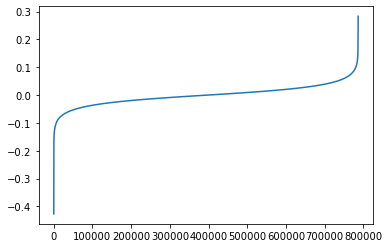

In [9]:
from special_neurons import find_linear_layer_pairs, ordered_magnitude_output
import matplotlib.pyplot as plt

linear_layer_pairs = find_linear_layer_pairs(model)
LAYER_PLOT = 0

plt.plot(ordered_magnitude_output(linear_layer_pairs[LAYER_PLOT])[0].flatten().sort()[0].cpu().detach().numpy())

## Look at the most negative wire settings

In [29]:
import transformer_lens

def get_weights_from_transformer_lens(name: str):
  #  TODO: this is a hack with gpt_ne_x
  match = re.match(r"gpt_neox\.layers\.(\d+)\.mlp", name)
  if not match:
    raise ValueError(f"Name {name} does not match the expected pattern")
  print(name)
  layer_number = int(match.group(1))
  hooked_name = f"blocks.{layer_number}.mlp.hook_post"
  print(activations[hooked_name].shape)
  return hooked_name

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained(model_name)
# Run the model and get logits and activations
logits, activations = model.run_with_cache("the umpires, the umpires, the umpires, the umpires")

# For the first MLP
LAYER_CHECK = 2
trans_lens_name = get_weights_from_transformer_lens(linear_layer_pairs[LAYER_CHECK].prev_layer_name)
weights_layer = linear_layer_pairs[LAYER_CHECK].linear_layer.weight
activations_prev_layer = activations[trans_lens_name]
activations_prev_layer = activations_prev_layer.squeeze(0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
gpt_neox.layers.0.mlp
torch.Size([1, 20, 2048])


In [30]:
weights_layer.shape, activations_prev_layer.shape

(torch.Size([2048, 512]), torch.Size([20, 2048]))

In [32]:

FOR_TOK = 0
most_min = float('inf')
most_min_index= -1
mins = torch.zeros_like(weights_layer[0])
for outgoing_wire in range(weights_layer.shape[1]):
	v = min(activations_prev_layer[FOR_TOK] * weights_layer.T[outgoing_wire])
	if v < most_min:
		most_min = v
		most_min_index = outgoing_wire
	mins[outgoing_wire] = v
print("MINS", most_min_index, most_min)
plt.plot(mins.sort()[0].cpu().detach().numpy())

## Look at most negative individual neuron

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Replace MODEL_NAME with the actual model name

# Encode the input text
input_text = "The boy with the SFdfdrgfeDSSD"  # Replace YOUR_INPUT_TEXT with your actual input text
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# Forward pass to get output logits
outputs = model(input_ids, output_hidden_states=True)
hidden_states = outputs.hidden_states  # Hidden states of all layers

# Access the specific neuron's value
# Replace LAYER_INDEX, BATCH_INDEX, TOKEN_INDEX, NEURON_INDEX with actual indices
# neuron_value = hidden_states[LAYER_INDEX][BATCH_INDEX, TOKEN_INDEX, NEURON_INDEX].item()

print(hidden_states[2].shape)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


torch.Size([1, 12, 512])


In [5]:
import transformer_lens

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained(model_name)
# Run the model and get logits and activations
logits, activations = model.run_with_cache("Hello World")

ModuleNotFoundError: No module named 'transformer_lens'

In [ ]:
activations

ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bloc

In [ ]:
N_MAX_LOOK = 100

# Okie, this is what we want!!


def find_logits_on_mlps():
    for layer_pair in most_neg:
        name = layer_pair.prev_layer_name
        match = re.match(r"gpt_neox\.layers\.(\d+)\.mlp", name)
        if match:
            print(name)
            layer_number = int(match.group(1))
            hooked_name = f"blocks.{layer_number}.mlp.hook_post"
            print(activations[hooked_name].shape)
            # Find the most positive activations
            # TODO: this is weird... it has to be **per token**
            most_neg_out = layer_pair.most_negatives.tolist()
            n_tokens = activations[hooked_name].shape[1]
            print("N Tokens", n_tokens)
            for tok_idx in range(n_tokens):
                maxed = activations[hooked_name][0, tok_idx].argsort(descending=True)[
                    :N_MAX_LOOK]
                for m in maxed:
                    for j in range(len(most_neg_out)):
                        if m == most_neg_out[j]:
                            print(f"Found a match: {m}")
                            # TODO: print token
                            print(
                                f"Activations: {activations[hooked_name][:, tok_idx, m]} on token {tok_idx} with negative value {layer_pair.most_negatives_vals[j]}")
                            effective_change = layer_pair.most_negatives_vals[j] * activations[hooked_name][:, tok_idx, m]
                            print("Effective change", effective_change.item())
                            print()


find_logits_on_mlps()

gpt_neox.layers.0.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 227
Activations: tensor([0.4309], device='cuda:0') on token 1 with negative value -13.506959915161133
Effective change tensor([-5.8199], device='cuda:0', grad_fn=<MulBackward0>)

Found a match: 249
Activations: tensor([0.3862], device='cuda:0') on token 1 with negative value -74.46073150634766
Effective change tensor([-28.7561], device='cuda:0', grad_fn=<MulBackward0>)

gpt_neox.layers.1.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 47
Activations: tensor([1.0227], device='cuda:0') on token 1 with negative value -17.482093811035156
Effective change tensor([-17.8796], device='cuda:0', grad_fn=<MulBackward0>)

Found a match: 157
Activations: tensor([0.5185], device='cuda:0') on token 2 with negative value -21.773366928100586
Effective change tensor([-11.2893], device='cuda:0', grad_fn=<MulBackward0>)

gpt_neox.layers.2.mlp
torch.Size([1, 3, 2048])
N Tokens 3
Found a match: 111
Activations: tensor([0.8778], 